<a href="https://colab.research.google.com/github/simran-sharma29/MSC-IT-PARTII-SEM-3/blob/main/DL/PRACT5/C/DLPRACT5c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Practical 5c
Aim:Data Augmentation



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [ ]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


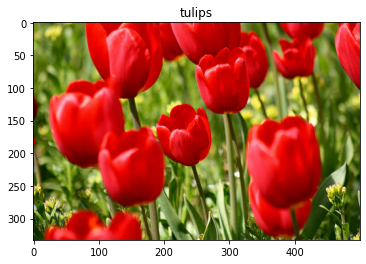

In [ ]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [ ]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

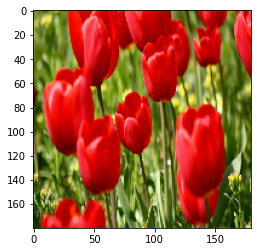

In [ ]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

In [ ]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())


Min and max pixel values: 0.0 1.0


In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [ ]:
# Add the image to a batch.
image = tf.expand_dims(image, 0)

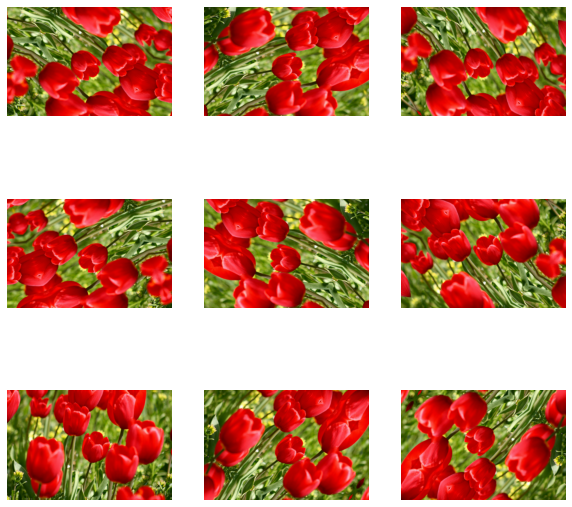

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [ ]:
model = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Rest of your model.
])

In [ ]:
aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

In [ ]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [ ]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
92/92 [==============================] - 101s 1s/step - loss: 1.3471 - accuracy: 0.4332 - val_loss: 1.2456 - val_accuracy: 0.4496
Epoch 2/5
92/92 [==============================] - 96s 1s/step - loss: 1.0775 - accuracy: 0.5668 - val_loss: 1.0346 - val_accuracy: 0.6076
Epoch 3/5
92/92 [==============================] - 97s 1s/step - loss: 0.9783 - accuracy: 0.6213 - val_loss: 0.9067 - val_accuracy: 0.6540
Epoch 4/5
92/92 [==============================] - 97s 1s/step - loss: 0.9128 - accuracy: 0.6291 - val_loss: 0.9433 - val_accuracy: 0.6431
Epoch 5/5
92/92 [==============================] - 96s 1s/step - loss: 0.8681 - accuracy: 0.6591 - val_loss: 0.8890 - val_accuracy: 0.6676


In [ ]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

12/12 [==============================] - 4s 287ms/step - loss: 0.8532 - accuracy: 0.6485
Accuracy 0.6485013365745544


In [ ]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

In [ ]:
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

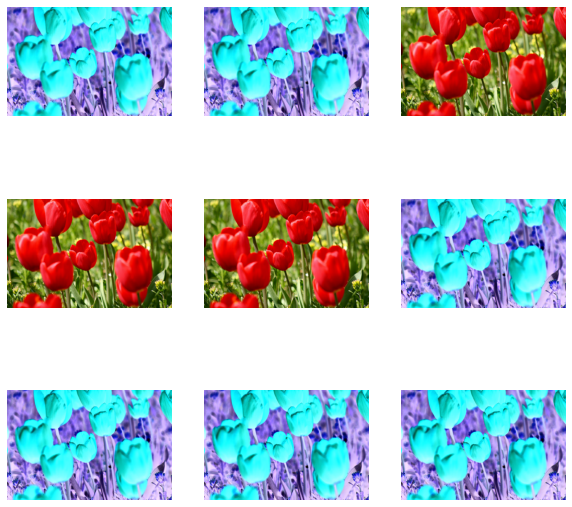

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = random_invert(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

In [ ]:
class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)

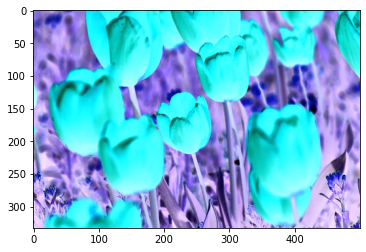

In [ ]:
_ = plt.imshow(RandomInvert()(image)[0])

In [ ]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

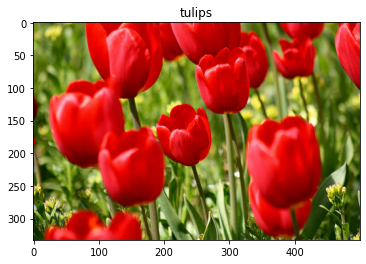

In [ ]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [ ]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

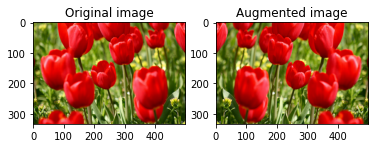

In [ ]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

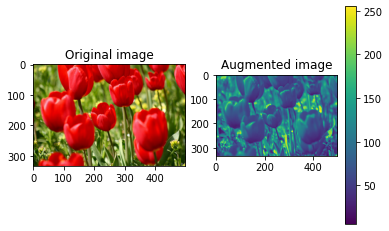

In [ ]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

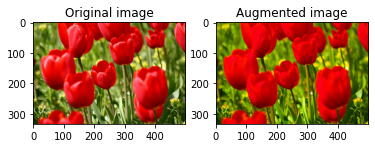

In [ ]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

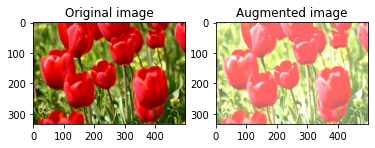

In [ ]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

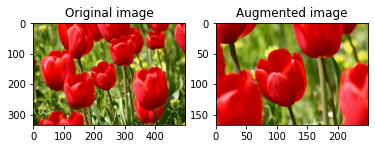

In [ ]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image,cropped)

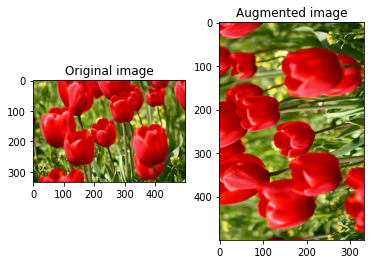

In [ ]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

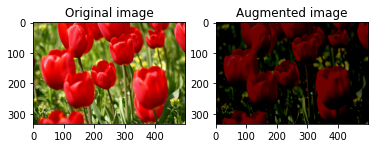

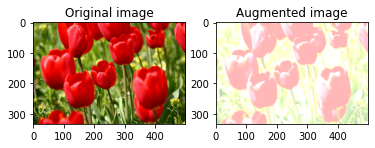

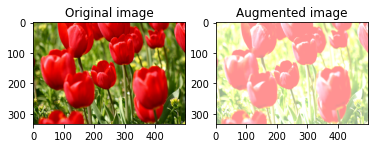

In [ ]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_brightness = tf.image.stateless_random_brightness(
      image, max_delta=0.95, seed=seed)
  visualize(image, stateless_random_brightness)

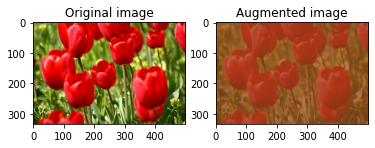

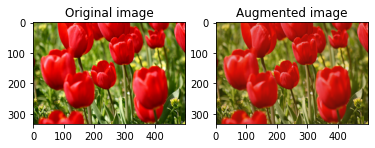

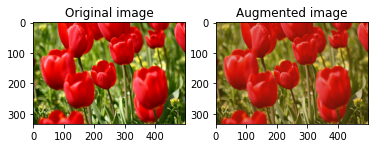

In [ ]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_contrast = tf.image.stateless_random_contrast(
      image, lower=0.1, upper=0.9, seed=seed)
  visualize(image, stateless_random_contrast)

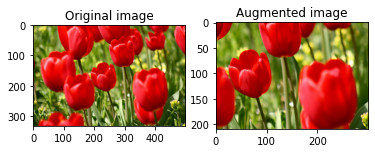

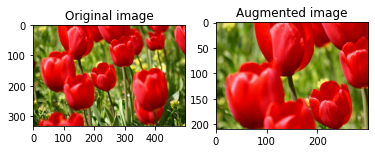

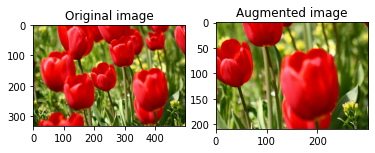

In [ ]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_crop = tf.image.stateless_random_crop(
      image, size=[210, 300, 3], seed=seed)
  visualize(image, stateless_random_crop)

In [ ]:
(train_datasets, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [ ]:
def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image, label

In [ ]:
def augment(image_label, seed):
  image, label = image_label
  image, label = resize_and_rescale(image, label)
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
  # Make a new seed.
  new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
  # Random crop back to the original size.
  image = tf.image.stateless_random_crop(
      image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed)
  # Random brightness.
  image = tf.image.stateless_random_brightness(
      image, max_delta=0.5, seed=new_seed)
  image = tf.clip_by_value(image, 0, 1)
  return image, label

In [ ]:
# Create a `Counter` object and `Dataset.zip` it together with the trainining set.
counter = tf.data.experimental.Counter()
train_ds = tf.data.Dataset.zip((train_datasets, (counter, counter)))

Instructions for updating:
Use `tf.data.Dataset.scan(...) instead


Instructions for updating:
Use `tf.data.Dataset.scan(...) instead


In [ ]:
train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
# Create a generator.
rng = tf.random.Generator.from_seed(123, alg='philox')

In [ ]:
# Create a wrapper function for updating seeds.
def f(x, y):
  seed = rng.make_seeds(2)[0]
  image, label = augment((x, y), seed)
  return image, label

In [ ]:
train_ds = (
    train_datasets
    .shuffle(1000)
    .map(f, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)